In [1]:
# import das bibliotecas
import psycopg2

import flask
from flask import Flask
from flask import request, jsonify, send_file, abort

import numpy as np
import pandas as pd
import pandas.io.sql as sqlio

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.dfg import converter as dfg_mining
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.algo.filtering.log.variants import variants_filter

In [2]:
db_host = "postgres"
db_port = "5432"
db_name = "dbinovacnj"
db_user = "inovacnj"
db_pass = "inovacnj@admin"

In [3]:
def gerar_modelo_pm_from_params(codtribunal, grau, codorgaoj, natureza, codclasse, dtinicio, dtfim, sensibilidade):
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    
    qry = "SELECT npu, fase || ' : ' || descmovimento as atividade, mov_dtmov "
    qry+= "FROM inovacnj.fat_movimentos_te "
    qry+= "WHERE (1=1) "
    if codtribunal != None :
        qry+= "AND codtribunal = '" + codtribunal + "' "
    if codorgaoj != None :
        qry+= "AND oj_cod = '" + codorgaoj + "' "
    if grau != None :
        qry+= "AND grau = '" + grau + "' "
    if natureza != None :
        qry+= "AND natureza = '" + natureza + "' "
    if codclasse != None :
        qry+= "AND codclasse = " + str(codclasse) + " "
        
    if dtinicio != None and dtfim != None:
        qry+= "AND mov_dtmov BETWEEN to_timestamp('" + dtinicio + "', 'yyyy-MM-dd') AND to_timestamp('" + dtfim + "', 'yyyy-MM-dd') "
        
    qry+= "ORDER BY mov_dtmov ASC "
    
    df_logeventos_pd = sqlio.read_sql_query(qry, conn)
      
    #df_logeventos_pd.to_csv('./output/log_eventos_2.csv', mode='a', header=True, sep = ";", index=False, chunksize=1000)
    
    gviz = None
    
    if df_logeventos_pd.size > 0 :
    
        dataframe = pm4py.format_dataframe(df_logeventos_pd, case_id='npu', activity_key='atividade', timestamp_key='mov_dtmov')
        eventLog = pm4py.convert_to_event_log(dataframe)
        if sensibilidade != None :
            eventLog = variants_filter.filter_log_variants_percentage(eventLog, percentage=float(sensibilidade) / 100)

        parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
        dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
        
        #net, im, fm = dfg_mining.apply(dfg)
        #gviz = pn_visualizer.apply(net, im, fm)
        gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE, parameters=parameters)
    
    return gviz

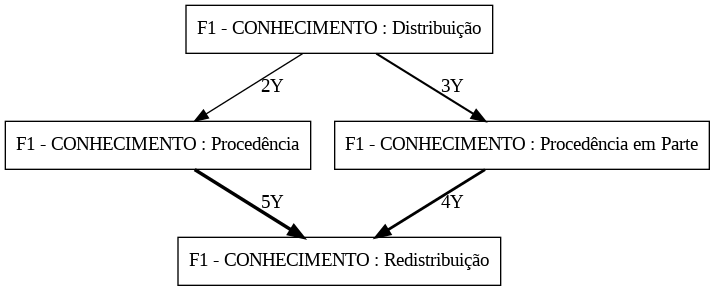

In [4]:
gviz = gerar_modelo_pm_from_params('TJPE', None, '7628', 'CIVEL', 7, None, None, 0.4)
if gviz != None:
    dfg_visualization.view(gviz)
else:
    print("sem dados")

In [5]:
import random
import string

def get_random_string(length):
    # Random string with the combination of lower and upper case
    letters = string.ascii_letters
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [ ]:
app = Flask(__name__)

@app.route('/api/v1/tipo-justica')
def api_lista_tipojustica():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT tipo as cod, tipo as descricao "
    qry+= "FROM inovacnj.tribunal"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/porte')
def api_lista_porte():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT porte as cod, porte as descricao "
    qry+= "FROM inovacnj.tribunal"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/tribunal')
def api_lista_tribunal():
    porte = request.args.get('porte')
    tipo = request.args.get('tipo')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT cod, descricao, sigla, tipo, porte "
    qry+= "FROM inovacnj.tribunal "
    qry+= "WHERE (1=1) "
    if porte != None :
        qry+= "AND porte = '" + porte + "' "
    if tipo != None :
        qry+= "AND tipo = '" + tipo + "' "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/orgao-julgador')
def api_lista_orgao_julgador():
    codtribunal = request.args.get('codtribunal')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT oj_cod, oj_instancia, oj_descricao, codtribunal "
    qry+= "FROM inovacnj.fat_movimentos_te "
    qry+= "WHERE (1=1) "
    if codtribunal != None :
        qry+= "AND codtribunal = '" + codtribunal + "' "
    qry+= "ORDER BY codtribunal, oj_descricao "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/natureza')
def api_lista_natureza():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT distinct natureza as codnatureza, natureza as descricao "
    qry+= "FROM inovacnj.movimentocnj "
    qry+= "WHERE natureza IS NOT NULL "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/classe')
def api_lista_classe():
    natureza = request.args.get('natureza')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT cod, descricao, sigla, codpai "
    qry+= "FROM inovacnj.classe "
    qry+= "WHERE (1=1)"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/movimento')
def api_lista_movimento():
    natureza = request.args.get('natureza')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
      
    qry = "SELECT cod, descricao, natureza, fase, codpai "
    qry+= "FROM inovacnj.movimentocnj "
    qry+= "WHERE (1=1)"
    if natureza != None :
        qry+= "AND natureza = '" + natureza + "' "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/assuntos-ranking')
def api_lista_assuntos_ranking():
    tipo = request.args.get('tipo')
    codtribunal = request.args.get('codtribunal')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
      
    qry = "SELECT descassunto as assunto, count(distinct npu) as quantidade "
    qry+= "FROM inovacnj.fat_movimentos_te, inovacnj.tribunal "
    qry+= "WHERE (1=1) "
    qry+= "AND fat_movimentos_te.codtribunal = tribunal.cod "
    if tipo != None :
        qry+= "AND tribunal.tipo = '" + tipo + "' "
    if codtribunal != None :
        qry+= "AND tribunal.cod = '" + codtribunal + "' "
    if codorgaoj != None :
        qry+= "AND fat_movimentos_te.oj_cod = '" + codorgaoj + "' "
    if natureza != None :
        qry+= "AND fat_movimentos_te.natureza = '" + natureza + "' "
    if codclasse != None :
        qry+= "AND fat_movimentos_te.codclasse = '" + codclasse + "' "
        
    qry+= "GROUP BY descassunto "
    qry+= "ORDER BY quantidade desc "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)


@app.route('/api/v1/gerar-modelo-pm')
def api_gerar_modelo_pm():
    codtribunal = request.args.get('codtribunal')
    grau = request.args.get('grau')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    dtinicio = request.args.get('dtinicio')
    dtfim = request.args.get('dtfim')
    sensibilidade = request.args.get('sensibilidade')
    
    
    if codtribunal is None:
        abort(400, description="codtribunal nao informado")
    if natureza is None:
        abort(400, description="natureza nao informado")
    
    gviz = gerar_modelo_pm_from_params(codtribunal, grau, codorgaoj, natureza, codclasse, dtinicio, dtfim, sensibilidade)
    if gviz != None:
        #dfg_visualization.view(gviz)
        path = "./output/modelo_pm_" + get_random_string(8) + ".png"
        dfg_visualization.save(gviz, path)
        return send_file(path, as_attachment=True)
    else:
        print("sem dados")
        abort(404, description="Nao encontrado")
    

app.run(host='0.0.0.0', port='8080')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:55:13] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:55:13] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:55:13] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:55:13] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:55:13] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:55:13] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:55:14] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:58:03] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:58:03] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [21/Oct/2020 17:58:03] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:we